# Collaboration and Competition

---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='../apps/Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import copy
from collections import deque, namedtuple

In [5]:
# Models
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Critic(nn.Module):
    def __init__(self, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(48, 400)
        self.fc2 = nn.Linear(404, 300)
        self.fc3 = nn.Linear(300, 2)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, states, actions):
        states = states.reshape(-1, 48)
        actions = actions.reshape(-1, 4)
        x = F.relu(self.fc1(states))
        x = torch.cat((x, actions), -1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Actor(nn.Module):
    def __init__(self, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(24, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 2)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, states):
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

In [6]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.actor = Actor(1)
        self.critic = Critic(1)
        self.critic_target = Critic(1)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr = 1e-4)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr = 1e-4)
        self.states = torch.empty(100000, num_agents, 24)
        self.actions = torch.empty(100000, num_agents, 2)
        self.rewards = torch.empty(100000, num_agents, 1)
        self.next_states = torch.empty(100000, num_agents, 24)
        self.dones = torch.empty(100000, num_agents, 1)
        self.idx = 0
        self.count = 0
        self.scale = 2
    
    def act(self, states):
        with torch.no_grad():
            actions = self.actor(states)
        self.scale *= 0.9999
        actions += np.random.standard_normal(2) * self.scale
        return np.clip(actions, -1, 1)
    
    def push(self, states, actions, rewards, next_states, dones):
        self.states[self.idx] = states
        self.actions[self.idx] = actions
        self.rewards[self.idx] = torch.tensor(rewards, dtype = torch.float).unsqueeze(1)
        self.next_states[self.idx] = next_states
        self.dones[self.idx] = torch.tensor(dones, dtype = torch.float).unsqueeze(1)
        
        self.count += 1
        self.idx = self.count % 100000
        
    def sample(self):
        sample_range = min(self.count, 99999)
        batch_idxs = random.sample(range(sample_range), 128)
        return self.states[batch_idxs], self.actions[batch_idxs], self.rewards[batch_idxs], self.next_states[batch_idxs], self.dones[batch_idxs]

    def step(self):
        if self.count >= 128:
            states, actions, rewards, next_states, dones = self.sample()
            next_actions = self.actor(next_states)
            td_error = torch.mean((rewards + 0.99 * self.critic_target(next_states, next_actions).unsqueeze(2) * \
                                   (1 - dones) - self.critic(states, actions).unsqueeze(2))**2)
            
            self.optimizer_critic.zero_grad()
            td_error.backward()
            self.optimizer_critic.step()
            for target_param, local_param in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_param.data.copy_(0.001*local_param.data + (1.0-0.001)*target_param.data)
                    
            actions_pred = self.actor(states)
            rewards_pred = self.critic(states, actions_pred).unsqueeze(2)
            rewards_calc = -torch.mean(rewards_pred)
            
            self.optimizer_actor.zero_grad()
            rewards_calc.backward()
            self.optimizer_actor.step()

agent = Agent()

In [7]:
scores = []
scores_window = deque(maxlen=100)
scores_window_3 = deque(maxlen=3)
for i in range(3000):                                         
    env_info = env.reset(train_mode=True)[brain_name]     
    states = torch.tensor(env_info.vector_observations, dtype = torch.float) 
    score = np.zeros(num_agents)
    count = 0
    while True:
        actions = agent.act(states)
        env_info = env.step(actions.cpu().data.numpy())[brain_name]           
        next_states = torch.tensor(env_info.vector_observations, dtype = torch.float)       
        rewards = env_info.rewards
        dones = env_info.local_done                        
        score += env_info.rewards
        agent.push(states, actions, rewards, next_states, dones)
        if len(scores_window)<=2 or np.mean(scores_window_3)<2.5 or count % 10 == 0:
            agent.step()
        states = next_states    
        count += 1
        if np.any(dones):                                  
            break
    scores.append(np.max(score))
    scores_window.append(np.max(score))  
    scores_window_3.append(np.max(score))
    
    print('\rEpisode {}\tReward: {:.5f}\tAverage Reward: {:.5f}'.format(i, np.max(score), np.mean(scores_window)))
    if np.mean(scores_window) >= 2.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, np.mean(scores_window)))
        torch.save(agent.critic.state_dict(), 'checkpoint/trained_weights_ddpg_v2_critic.pth')
        torch.save(agent.actor.state_dict(), 'checkpoint/trained_weights_ddpg_v2_policy.pth')
        break

/anaconda3/envs/reacher_ddpg/lib/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 0	Reward: 0.00000	Average Reward: 0.00000
Episode 1	Reward: 0.09000	Average Reward: 0.04500
Episode 2	Reward: 0.00000	Average Reward: 0.03000
Episode 3	Reward: 0.00000	Average Reward: 0.02250
Episode 4	Reward: 0.00000	Average Reward: 0.01800
Episode 5	Reward: 0.10000	Average Reward: 0.03167
Episode 6	Reward: 0.00000	Average Reward: 0.02714
Episode 7	Reward: 0.00000	Average Reward: 0.02375
Episode 8	Reward: 0.00000	Average Reward: 0.02111
Episode 9	Reward: 0.00000	Average Reward: 0.01900
Episode 10	Reward: 0.00000	Average Reward: 0.01727
Episode 11	Reward: 0.00000	Average Reward: 0.01583
Episode 12	Reward: 0.00000	Average Reward: 0.01462
Episode 13	Reward: 0.00000	Average Reward: 0.01357
Episode 14	Reward: 0.00000	Average Reward: 0.01267
Episode 15	Reward: 0.00000	Average Reward: 0.01188
Episode 16	Reward: 0.00000	Average Reward: 0.01118
Episode 17	Reward: 0.00000	Average Reward: 0.01056
Episode 18	Reward: 0.00000	Average Reward: 0.01000
Episode 19	Reward: 0.00000	Average Reward

Episode 160	Reward: 0.00000	Average Reward: 0.00990
Episode 161	Reward: 0.00000	Average Reward: 0.00990
Episode 162	Reward: 0.00000	Average Reward: 0.00990
Episode 163	Reward: 0.00000	Average Reward: 0.00990
Episode 164	Reward: 0.00000	Average Reward: 0.00990
Episode 165	Reward: 0.00000	Average Reward: 0.00990
Episode 166	Reward: 0.09000	Average Reward: 0.01080
Episode 167	Reward: 0.10000	Average Reward: 0.01180
Episode 168	Reward: 0.00000	Average Reward: 0.01180
Episode 169	Reward: 0.00000	Average Reward: 0.01180
Episode 170	Reward: 0.00000	Average Reward: 0.01180
Episode 171	Reward: 0.00000	Average Reward: 0.01180
Episode 172	Reward: 0.00000	Average Reward: 0.01080
Episode 173	Reward: 0.00000	Average Reward: 0.01080
Episode 174	Reward: 0.00000	Average Reward: 0.01080
Episode 175	Reward: 0.00000	Average Reward: 0.01080
Episode 176	Reward: 0.00000	Average Reward: 0.01080
Episode 177	Reward: 0.00000	Average Reward: 0.01080
Episode 178	Reward: 0.00000	Average Reward: 0.00980
Episode 179	

Episode 318	Reward: 0.10000	Average Reward: 0.03490
Episode 319	Reward: 0.00000	Average Reward: 0.03400
Episode 320	Reward: 0.10000	Average Reward: 0.03500
Episode 321	Reward: 0.10000	Average Reward: 0.03400
Episode 322	Reward: 0.10000	Average Reward: 0.03410
Episode 323	Reward: 0.09000	Average Reward: 0.03500
Episode 324	Reward: 0.00000	Average Reward: 0.03400
Episode 325	Reward: 0.00000	Average Reward: 0.03300
Episode 326	Reward: 0.00000	Average Reward: 0.03200
Episode 327	Reward: 0.00000	Average Reward: 0.03200
Episode 328	Reward: 0.00000	Average Reward: 0.03010
Episode 329	Reward: 0.00000	Average Reward: 0.03010
Episode 330	Reward: 0.00000	Average Reward: 0.02920
Episode 331	Reward: 0.00000	Average Reward: 0.02920
Episode 332	Reward: 0.00000	Average Reward: 0.02920
Episode 333	Reward: 0.00000	Average Reward: 0.02830
Episode 334	Reward: 0.00000	Average Reward: 0.02830
Episode 335	Reward: 0.10000	Average Reward: 0.02930
Episode 336	Reward: 0.00000	Average Reward: 0.02930
Episode 337	

Episode 476	Reward: 0.00000	Average Reward: 0.05510
Episode 477	Reward: 0.00000	Average Reward: 0.05410
Episode 478	Reward: 0.00000	Average Reward: 0.05320
Episode 479	Reward: 0.09000	Average Reward: 0.05320
Episode 480	Reward: 0.00000	Average Reward: 0.05320
Episode 481	Reward: 0.09000	Average Reward: 0.05410
Episode 482	Reward: 0.00000	Average Reward: 0.05320
Episode 483	Reward: 0.10000	Average Reward: 0.05420
Episode 484	Reward: 0.00000	Average Reward: 0.05320
Episode 485	Reward: 0.09000	Average Reward: 0.05410
Episode 486	Reward: 0.00000	Average Reward: 0.05310
Episode 487	Reward: 0.00000	Average Reward: 0.05220
Episode 488	Reward: 0.00000	Average Reward: 0.05220
Episode 489	Reward: 0.00000	Average Reward: 0.05120
Episode 490	Reward: 0.00000	Average Reward: 0.05120
Episode 491	Reward: 0.00000	Average Reward: 0.05120
Episode 492	Reward: 0.00000	Average Reward: 0.05120
Episode 493	Reward: 0.00000	Average Reward: 0.05120
Episode 494	Reward: 0.00000	Average Reward: 0.05020
Episode 495	

Episode 634	Reward: 0.00000	Average Reward: 0.06210
Episode 635	Reward: 0.10000	Average Reward: 0.06310
Episode 636	Reward: 0.00000	Average Reward: 0.06310
Episode 637	Reward: 0.10000	Average Reward: 0.06410
Episode 638	Reward: 0.19000	Average Reward: 0.06600
Episode 639	Reward: 0.10000	Average Reward: 0.06610
Episode 640	Reward: 0.10000	Average Reward: 0.06710
Episode 641	Reward: 0.10000	Average Reward: 0.06720
Episode 642	Reward: 0.09000	Average Reward: 0.06810
Episode 643	Reward: 0.00000	Average Reward: 0.06810
Episode 644	Reward: 0.09000	Average Reward: 0.06900
Episode 645	Reward: 0.00000	Average Reward: 0.06810
Episode 646	Reward: 0.09000	Average Reward: 0.06800
Episode 647	Reward: 0.09000	Average Reward: 0.06800
Episode 648	Reward: 0.09000	Average Reward: 0.06890
Episode 649	Reward: 0.10000	Average Reward: 0.06890
Episode 650	Reward: 0.10000	Average Reward: 0.06990
Episode 651	Reward: 0.09000	Average Reward: 0.06980
Episode 652	Reward: 0.10000	Average Reward: 0.06980
Episode 653	

Episode 792	Reward: 0.20000	Average Reward: 0.10130
Episode 793	Reward: 0.10000	Average Reward: 0.10130
Episode 794	Reward: 0.80000	Average Reward: 0.10930
Episode 795	Reward: 0.50000	Average Reward: 0.11430
Episode 796	Reward: 0.80000	Average Reward: 0.12140
Episode 797	Reward: 0.10000	Average Reward: 0.12140
Episode 798	Reward: 0.10000	Average Reward: 0.12140
Episode 799	Reward: 0.10000	Average Reward: 0.12150
Episode 800	Reward: 0.10000	Average Reward: 0.12150
Episode 801	Reward: 0.90000	Average Reward: 0.12950
Episode 802	Reward: 0.50000	Average Reward: 0.13360
Episode 803	Reward: 0.20000	Average Reward: 0.13470
Episode 804	Reward: 0.10000	Average Reward: 0.13480
Episode 805	Reward: 0.10000	Average Reward: 0.13480
Episode 806	Reward: 0.10000	Average Reward: 0.13490
Episode 807	Reward: 0.10000	Average Reward: 0.13500
Episode 808	Reward: 0.30000	Average Reward: 0.13800
Episode 809	Reward: 0.10000	Average Reward: 0.13900
Episode 810	Reward: 0.10000	Average Reward: 0.14000
Episode 811	

Episode 950	Reward: 2.70000	Average Reward: 1.16330
Episode 951	Reward: 2.60000	Average Reward: 1.18730
Episode 952	Reward: 2.70000	Average Reward: 1.21330
Episode 953	Reward: 2.60000	Average Reward: 1.23830
Episode 954	Reward: 2.70000	Average Reward: 1.26430
Episode 955	Reward: 2.60000	Average Reward: 1.28930
Episode 956	Reward: 2.70000	Average Reward: 1.31530
Episode 957	Reward: 2.70000	Average Reward: 1.34130
Episode 958	Reward: 2.60000	Average Reward: 1.36330
Episode 959	Reward: 2.70000	Average Reward: 1.38930
Episode 960	Reward: 2.60000	Average Reward: 1.41440
Episode 961	Reward: 2.70000	Average Reward: 1.44050
Episode 962	Reward: 2.60000	Average Reward: 1.46550
Episode 963	Reward: 2.70000	Average Reward: 1.49150
Episode 964	Reward: 2.60000	Average Reward: 1.51450
Episode 965	Reward: 2.70000	Average Reward: 1.54060
Episode 966	Reward: 2.70000	Average Reward: 1.56660
Episode 967	Reward: 2.60000	Average Reward: 1.58860
Episode 968	Reward: 2.70000	Average Reward: 1.61360
Episode 969	

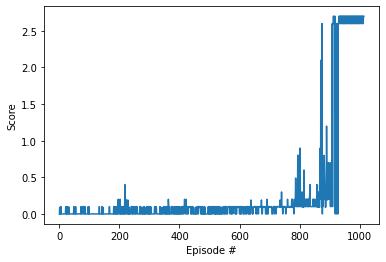

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
env.close()